In [59]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from typing import Union,Sequence

import pandas as pd
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import seaborn as sns
from atommic.collections.reconstruction.losses.haarpsi import haarpsi
import functools


In [60]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [61]:
# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [62]:
def haarpsi3d(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")
    reduction = 'mean'
    scales = 3
    subsample = True
    c = 30.0
    alpha = 4.2

    maxval = np.max(x) if maxval is None else maxval
    _haarpsi = functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
    if np.size(seg)==0:
        __haarpsi = sum(
            _haarpsi(torch.from_numpy(x[slice_num]).unsqueeze(0).float(),
                     torch.from_numpy(y[slice_num]).unsqueeze(0).float()) for slice_num in
            range(x.shape[0])
        ).numpy()
    else:
        __haarpsi = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                max_val = max(np.max(x_seg),np.max(y_seg))
                functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
                __haarpsi.append(_haarpsi(torch.from_numpy(x_seg).unsqueeze(0).float(),
                     torch.from_numpy(y_seg).unsqueeze(0).float()))
        __haarpsi=sum(__haarpsi)

    return __haarpsi / x.shape[0]

In [63]:
def ssim(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Computes Structural Similarity Index Measure (SSIM).

    Parameters
    ----------
    x : np.ndarray
        Target image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D images,
        the first dimension should be 1.
    y : np.ndarray
        Predicted image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D
        images, the first dimension should be 1.
    maxval : np.ndarray
        Maximum value of the images. If None, it is computed from the images. If the images are normalized, maxval
        should be 1.

    Returns
    -------
    float
        Structural Similarity Index Measure.

    Examples
    --------
    >>> from atommic.collections.reconstruction.metrics.reconstruction_metrics import ssim
    >>> import numpy as np
    >>> datax = np.random.rand(3, 100, 100)
    >>> datay = datax * 0.5
    >>> ssim(datax, datay)
    0.01833040155119426

    .. note::
        x and y must be normalized to the same range, e.g. [0, 1].

        The SSIM is computed using the scikit-image implementation of the SSIM metric.
        Source: https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity
    """
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match prediction dimensions.")

    maxval = max(np.max(x) - np.min(x), np.max(y) - np.min(y)) if maxval is None else maxval
    maxval = max(maxval, 1)
    if np.size(seg)==0:
        ssim_score = sum(
        structural_similarity(x[slice_num], y[slice_num], data_range=maxval) for slice_num in range(x.shape[0])
    )
    else:
        ssim_score = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                #maxval = max(np.max(x_seg) - np.min(x_seg), np.max(y_seg) - np.min(y_seg))
                ssim_score.append(structural_similarity(x_seg, y_seg, data_range=maxval))
        ssim_score = sum(ssim_score)
    return ssim_score / x.shape[0]

In [64]:
def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x**2).sum(dim=-1)

In [65]:
def check_stacked_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Check if tensor is stacked complex (real & imaginary parts stacked along last dim) and convert it to a combined
    complex tensor.

    Parameters
    ----------
    x : torch.Tensor
        Tensor to check.

    Returns
    -------
    torch.Tensor
        Tensor with stacked complex converted to combined complex.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import check_stacked_complex
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> data = torch.view_as_real(data)
    >>> data.shape
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    """
    return torch.view_as_complex(x) if x.shape[-1] == 2 else x

In [66]:
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/2024-01-17_16-08-12/MTLRS--MC-1/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_1 = f['reconstruction'][()].squeeze()
    segmentations_1  = f['segmentation'][()].squeeze()
    target_mtlrs_1  = f['target_reconstruction'][()].squeeze()
    segmentation_labels_org_1  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_1  = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_1  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_1  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_1 .shape,predictions_1 .shape,segmentation_labels_org_1 .shape,target_mtlrs_1 .shape, uncertainty_mtlrs_1 .shape,inter_rec_1 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/2024-01-17_16-08-12/MTLRS--MC-2/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_mtlrs_2 = f['reconstruction'][()].squeeze()
    # predictions_2  = f['segmentation'][()].squeeze()
    target_mtlrs_2  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_2  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_2  = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_2  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_2  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_2 .shape,predictions_2 .shape,segmentation_labels_org_2 .shape,target_mtlrs_2 .shape, uncertainty_mtlrs_2 .shape,inter_rec_2 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/2024-01-17_16-08-12/MTLRS--MC-3/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    # print(f.keys())
    # scan_mtlrs_3 = f['reconstruction'][()].squeeze()
    # predictions_3  = f['segmentation'][()].squeeze()
    target_mtlrs_3  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_3  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_3  = f['uncertainty'][()].squeeze()
    # zero_filled_3  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_3  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_3 .shape,predictions_3 .shape,segmentation_labels_org_3 .shape,target_mtlrs_3 .shape, uncertainty_mtlrs_3 .shape,inter_rec_3 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/2024-01-17_16-08-12/MTLRS--MC-4/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_mtlrs_4 = f['reconstruction'][()].squeeze()
    # predictions_4  = f['segmentation'][()].squeeze()
    target_mtlrs_4  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_4  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_4  = f['uncertainty'][()].squeeze()
    # zero_filled_4  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_4  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_4 .shape,predictions_4 .shape,segmentation_labels_org_4 .shape,target_mtlrs_4 .shape, uncertainty_mtlrs_4 .shape,inter_rec_4 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/2024-01-17_16-08-12/MTLRS--MC-5/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_5 = f['reconstruction'][()].squeeze()
    #predictions_5  = f['segmentation'][()].squeeze()
    target_mtlrs_5  = f['target_reconstruction'][()].squeeze()
    #segmentation_labels_org_5  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_5  = f['uncertainty'][()].squeeze()
    #zero_filled_5  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_5  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_5 .shape,predictions_5 .shape,segmentation_labels_org_5 .shape,target_mtlrs_5 .shape, uncertainty_mtlrs_5 .shape,inter_rec_5 .shape)
#print(scan_mtlrs_5-inter_rec_5[:,4,...])

<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>


In [67]:
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/2024-01-17_16-12-16/CIRIM--MC-1/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_cirim_1 = f['reconstruction'][()].squeeze()
    target_cirim_1  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_1  = f['uncertainty'][()].squeeze()
    zero_filled_cirim_1  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_1  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_1 .shape,predictions_1 .shape,segmentation_labels_org_1 .shape,target_cirim_1 .shape, uncertainty_cirim_1 .shape,inter_rec_1 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/2024-01-17_16-12-16/CIRIM--MC-2/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_cirim_2 = f['reconstruction'][()].squeeze()
    target_cirim_2  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_2  = f['uncertainty'][()].squeeze()
    # zero_filled_2  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_2  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_2 .shape,predictions_2 .shape,segmentation_labels_org_2 .shape,target_cirim_2 .shape, uncertainty_cirim_2 .shape,inter_rec_2 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/2024-01-17_16-12-16/CIRIM--MC-3/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    # print(f.keys())
    # scan_cirim_3 = f['reconstruction'][()].squeeze()
    # predictions_3  = f['segmentation'][()].squeeze()
    target_cirim_3  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_3  = f['target_segmentation'][()].squeeze()
    uncertainty_cirim_3  = f['uncertainty'][()].squeeze()
    # zero_filled_3  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_3  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_3 .shape,predictions_3 .shape,segmentation_labels_org_3 .shape,target_cirim_3 .shape, uncertainty_cirim_3 .shape,inter_rec_3 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/2024-01-17_16-12-16/CIRIM--MC-4/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_cirim_4 = f['reconstruction'][()].squeeze()
    target_cirim_4  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_4  = f['uncertainty'][()].squeeze()
    # zero_filled_4  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_4  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_4 .shape,predictions_4 .shape,segmentation_labels_org_4 .shape,target_cirim_4 .shape, uncertainty_cirim_4 .shape,inter_rec_4 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/2024-01-17_16-12-16/CIRIM--MC-5/None/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_cirim_5 = f['reconstruction'][()].squeeze()
    target_cirim_5  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_5  = f['uncertainty'][()].squeeze()
    #zero_filled_5  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_5  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
print(scan_cirim_5 .shape, uncertainty_cirim_5 .shape,inter_rec_cirim_5 .shape)
#print(scan_cirim_5-inter_rec_5[:,4,...])

<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
(74, 416, 512) (74, 5, 416, 512) (74, 2, 5, 416, 512)


In [68]:
#Check if zero filled and target are the same

print(np.unique(zero_filled_mtlrs_2.reshape(1,-1)-zero_filled_cirim_1.reshape(1,-1)))
print(np.unique(target_mtlrs_5.reshape(1,-1)-target_cirim_1.reshape(1,-1)))

[0.+0.j]
[0.+0.j]


(74, 5, 416, 512)


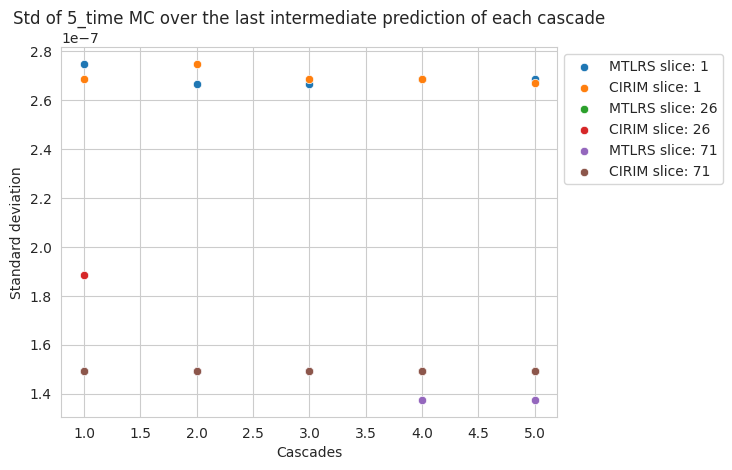

In [69]:
std_cirim = np.std([inter_rec_cirim_1[:,0,...],inter_rec_cirim_2[:,0,...],inter_rec_cirim_3[:,0,...],inter_rec_cirim_4[:,0,...],inter_rec_cirim_5[:,0,...]],axis=0,ddof=1)
std_mtlrs = np.std([inter_rec_mtlrs_1[:,0,...],inter_rec_mtlrs_2[:,0,...],inter_rec_mtlrs_3[:,0,...],inter_rec_mtlrs_4[:,0,...],inter_rec_mtlrs_5[:,0,...]],axis=0,ddof=1)
print(std_cirim.shape)
for slice in [0,25,70]:
    max_std_cirim = [np.max(std_cirim[slice,i].reshape(1,-1)) for i in range(std_cirim.shape[1])]
    max_std_mtlrs  = [np.max(std_mtlrs[slice,i].reshape(1,-1)) for i in range(std_mtlrs.shape[1])]
    data_frame = pd.DataFrame({'MTLRS':max_std_mtlrs,'CIRIM':max_std_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS,label =f"MTLRS slice: {slice+1}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM,label =f"CIRIM slice: {slice+1}")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Std of 5_time MC over the last intermediate prediction of each cascade')
plt.ylabel('Standard deviation')
plt.savefig('/scratch/tmpaquaij/Figures/STD_MC_5_IP.png')



(74, 5, 416, 512)
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


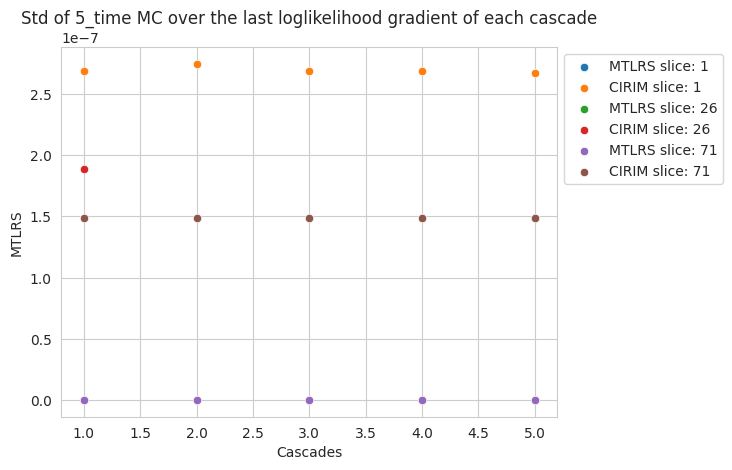

In [70]:
std_cirim = np.std([inter_rec_cirim_1[:,1,...],inter_rec_cirim_2[:,1,...],inter_rec_cirim_3[:,1,...],inter_rec_cirim_4[:,1,...],inter_rec_cirim_5[:,1,...]],axis=0,ddof=1)
std_mtlrs = np.std([inter_rec_mtlrs_1[:,1,...],inter_rec_mtlrs_2[:,1,...],inter_rec_mtlrs_3[:,1,...],inter_rec_mtlrs_4[:,1,...],inter_rec_mtlrs_5[:,1,...]],axis=0,ddof=1)
print(std_cirim.shape)
for slice in [0,25,70]:
    max_std_cirim = [np.max(std_cirim[slice,i].reshape(1,-1)) for i in range(std_cirim.shape[1])]
    max_std_mtlrs  = [np.max(std_mtlrs[slice,i].reshape(1,-1)) for i in range(std_mtlrs.shape[1])]
    print(max_std_mtlrs)
    data_frame = pd.DataFrame({'MTLRS':max_std_mtlrs,'CIRIM':max_std_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS,label =f"MTLRS slice: {slice+1}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM,label =f"CIRIM slice: {slice+1}")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Std of 5_time MC over the last loglikelihood gradient of each cascade')
plt.savefig('/scratch/tmpaquaij/Figures/STD_MC_5_LL.png')

Text(0, 0.5, 'Variance')

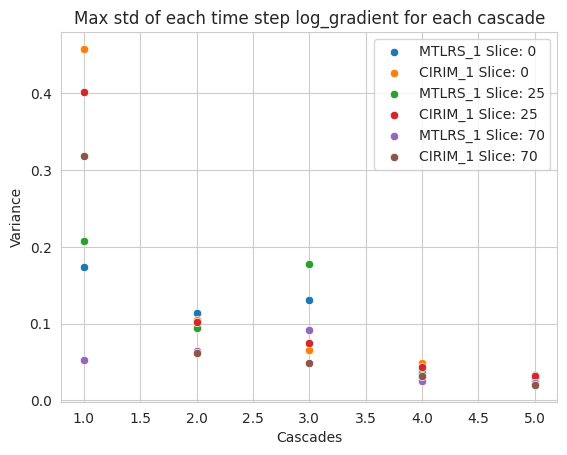

In [71]:

for idx in [0,25,70]:
    un_max_mtlrs = [np.max(np.sqrt(uncertainty_mtlrs_1[idx,i].reshape(1,-1))) for i in range(uncertainty_mtlrs_1.shape[1])]
    un_max_cirim = [np.max(np.sqrt(uncertainty_cirim_1[idx,i].reshape(1,-1)) )for i in range(uncertainty_cirim_1.shape[1])]
    data_frame = pd.DataFrame({'MTLRS':un_max_mtlrs,'CIRIM':un_max_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS, label= f"MTLRS_1 Slice: {idx}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM, label= f"CIRIM_1 Slice: {idx}")

plt.title("Max std of each time step log_gradient for each cascade")
plt.ylabel('Variance')

In [72]:
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/Ensemble/2024-01-27_10-36-54/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_1 = f['reconstruction'][()].squeeze()
    segmentations_1  = f['segmentation'][()].squeeze()
    target_mtlrs_1  = f['target_reconstruction'][()].squeeze()
    segmentation_labels_org_1  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_1  = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_1  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_1  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_1 .shape,predictions_1 .shape,segmentation_labels_org_1 .shape,target_mtlrs_1 .shape, uncertainty_mtlrs_1 .shape,inter_rec_1 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/Ensemble/2024-01-26_09-07-37/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_mtlrs_2 = f['reconstruction'][()].squeeze()
    # predictions_2  = f['segmentation'][()].squeeze()
    target_mtlrs_2  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_2  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_2  = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_2  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_2  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_2 .shape,predictions_2 .shape,segmentation_labels_org_2 .shape,target_mtlrs_2 .shape, uncertainty_mtlrs_2 .shape,inter_rec_2 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/Ensemble/2024-01-24_23-14-53/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    # print(f.keys())
    # scan_mtlrs_3 = f['reconstruction'][()].squeeze()
    # predictions_3  = f['segmentation'][()].squeeze()
    target_mtlrs_3  = f['target_reconstruction'][()].squeeze()
    # segmentation_labels_org_3  = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_3  = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_3  = f['zero_filled'][()].squeeze()
    inter_rec_mtlrs_3  = f['intermediate_reconstruction'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
# print(scan_mtlrs_3 .shape,predictions_3 .shape,segmentation_labels_org_3 .shape,target_mtlrs_3 .shape, uncertainty_mtlrs_3 .shape,inter_rec_3 .shape)

<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>


In [73]:
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/Ensemble/2024-01-24_13-53-35/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_cirim_1 = f['reconstruction'][()].squeeze()
    target_cirim_1  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_1  = f['uncertainty'][()].squeeze()
    zero_filled_cirim_1  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_1  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_1 .shape,predictions_1 .shape,segmentation_labels_org_1 .shape,target_cirim_1 .shape, uncertainty_cirim_1 .shape,inter_rec_1 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/Ensemble/2024-01-23_10-32-58/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_cirim_2 = f['reconstruction'][()].squeeze()
    target_cirim_2  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_2  = f['uncertainty'][()].squeeze()
    zero_filled_cirim_2  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_2  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_2 .shape,predictions_2 .shape,segmentation_labels_org_2 .shape,target_cirim_2 .shape, uncertainty_cirim_2 .shape,inter_rec_2 .shape)
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/CIRIM_SENSE/predictions_8x/Ensemble/2024-01-24_02-16-09/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    # scan_cirim_3 = f['reconstruction'][()].squeeze()
    target_cirim_3  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim_3  = f['uncertainty'][()].squeeze()
    zero_filled_cirim_3  = f['zero_filled'][()].squeeze()
    inter_rec_cirim_3  = f['intermediate_reconstruction'][()].squeeze()
#scan_cirim = inter_rec[:,0,...]
# print(scan_cirim_3 .shape,predictions_3 .shape,segmentation_labels_org_3 .shape,target_cirim_3 .shape, uncertainty_cirim_3 .shape,inter_rec_3 .shape)

<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'target_reconstruction', 'uncertainty', 'zero_filled']>


In [74]:
print(np.unique(zero_filled_cirim_1.reshape(1,-1)-zero_filled_cirim_2.reshape(1,-1)))
print(np.unique(target_mtlrs_1.reshape(1,-1)-target_cirim_2.reshape(1,-1)))

[0.+0.j]
[0.+0.j]


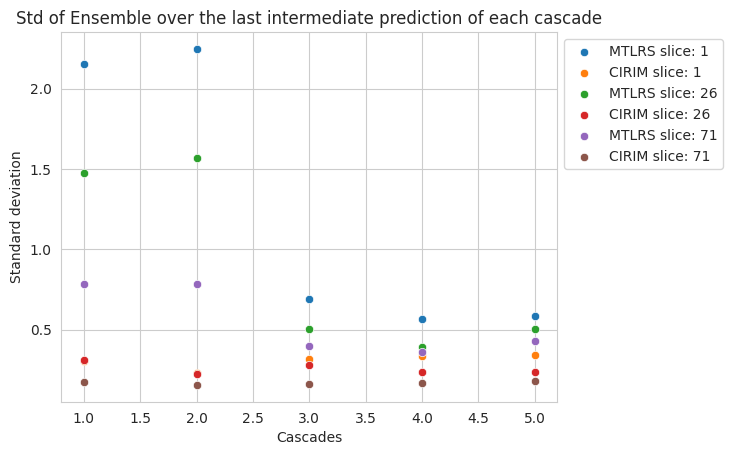

In [75]:
std_cirim = np.std([inter_rec_cirim_1[:,0,...],inter_rec_cirim_2[:,0,...],inter_rec_cirim_3[:,0,...]],axis=0,ddof=1)
std_mtlrs = np.std([inter_rec_mtlrs_1[:,0,...],inter_rec_mtlrs_2[:,0,...],inter_rec_mtlrs_3[:,0,...]],axis=0,ddof=1)
for slice in [0,25,70]:
    max_std_cirim = [np.max(std_cirim[slice,i].reshape(1,-1)) for i in range(std_cirim.shape[1])]
    max_std_mtlrs  = [np.max(std_mtlrs[slice,i].reshape(1,-1)) for i in range(std_mtlrs.shape[1])]
    data_frame = pd.DataFrame({'MTLRS':max_std_mtlrs,'CIRIM':max_std_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS,label =f"MTLRS slice: {slice+1}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM,label =f"CIRIM slice: {slice+1}")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Std of Ensemble over the last intermediate prediction of each cascade')
plt.ylabel('Standard deviation')
plt.savefig('/scratch/tmpaquaij/Figures/STD_ENS_5_IP.png')

[0.5090311, 0.028397445, 0.2432698, 0.06278264, 0.025568947]
[0.3447563, 0.029752612, 0.1443376, 0.035763286, 0.054042786]
[0.17127782, 0.05256604, 0.060695007, 0.01912804, 0.017369494]


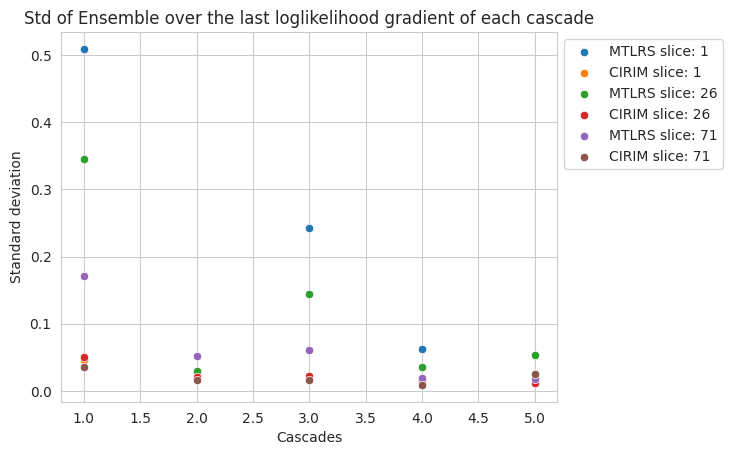

In [76]:
std_cirim = np.std([inter_rec_cirim_1[:,1,...],inter_rec_cirim_2[:,1,...],inter_rec_cirim_3[:,1,...]],axis=0,ddof=1)
std_mtlrs = np.std([inter_rec_mtlrs_1[:,1,...],inter_rec_mtlrs_2[:,1,...],inter_rec_mtlrs_3[:,1,...]],axis=0,ddof=1)
plt.figure()
for slice in [0,25,70]:
    max_std_cirim = [np.max(std_cirim[slice,i].reshape(1,-1)) for i in range(std_cirim.shape[1])]
    max_std_mtlrs  = [np.max(std_mtlrs[slice,i].reshape(1,-1)) for i in range(std_mtlrs.shape[1])]
    print(max_std_mtlrs)
    data_frame = pd.DataFrame({'MTLRS':max_std_mtlrs,'CIRIM':max_std_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS,label =f"MTLRS slice: {slice+1}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM,label =f"CIRIM slice: {slice+1}")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Std of Ensemble over the last loglikelihood gradient of each cascade')
plt.ylabel('Standard deviation')
plt.savefig('/scratch/tmpaquaij/Figures/STD_ENS_5_LL.png')

Text(0, 0.5, 'Sandard Deviation')

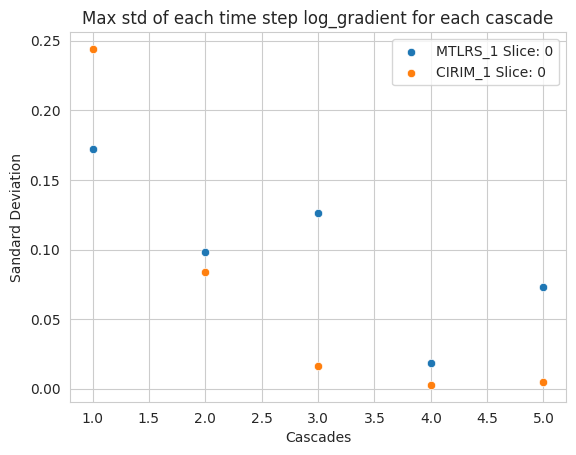

In [77]:
for idx in [0]:
    un_max_mtlrs = [np.max(np.sqrt(uncertainty_mtlrs_1[idx,i].reshape(1,-1))) for i in range(uncertainty_mtlrs_1.shape[1])]
    un_max_cirim = [np.max(np.sqrt(uncertainty_cirim_1[idx,i].reshape(1,-1)) )for i in range(uncertainty_cirim_1.shape[1])]
    data_frame = pd.DataFrame({'MTLRS':un_max_mtlrs,'CIRIM':un_max_cirim,'Cascades':[1,2,3,4,5]})
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS, label= f"MTLRS_1 Slice: {idx}")
    sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM, label= f"CIRIM_1 Slice: {idx}")

plt.title("Max std of each time step log_gradient for each cascade")
plt.ylabel('Sandard Deviation')